In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.stats import linregress
from sklearn.model_selection import KFold

import matplotlib
font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

import sys

sys.path.append("../../models")
from linear_sscr import LinearCR

In [7]:
# Load data
data_dir = "../../data/corrupted_lines"
X = np.load(pjoin(data_dir, "foreground.npy"))
Y = np.load(pjoin(data_dir, "background.npy"))
R = np.load(pjoin(data_dir, "foreground_labels.npy")).reshape(-1, 1)

# rand_idx = np.random.choice(np.arange(len(X)), size=200, replace=False)
# X = X[rand_idx]
# R = R[rand_idx]
# rand_idx = np.random.choice(np.arange(len(Y)), size=200, replace=False)
# Y = Y[rand_idx]

X_mean, Y_mean, R_mean = np.mean(X, axis=0), np.mean(Y, axis=0), np.mean(R, axis=0)
X = (X - X_mean) / np.std(X, axis=0)
Y = (Y - Y_mean) / np.std(Y, axis=0)
R = (R - R_mean) / np.std(R, axis=0)

n, p = X.shape
m, _ = Y.shape
d = 2


In [8]:
X.shape, Y.shape

((5000, 784), (5000, 784))

In [9]:
model = LinearSSCR()
model.fit(X, Y, R, d, print_every=100)

Step: 0               Log marginal lik.: -3941756.25
Step: 100             Log marginal lik.: -1106149.0
Step: 200             Log marginal lik.: -1095091.38
Step: 300             Log marginal lik.: -1091416.5
Step: 400             Log marginal lik.: -1089826.25
Step: 500             Log marginal lik.: -1088988.12
Step: 600             Log marginal lik.: -1088490.62
Step: 700             Log marginal lik.: -1088172.88
Step: 800             Log marginal lik.: -1087961.25
Step: 900             Log marginal lik.: -1087815.25
Step: 1000            Log marginal lik.: -1087713.12
Step: 1100            Log marginal lik.: -1087640.38


In [10]:
# Make predictions
preds_contrastivereg = model.predict(X)
_, _, r2_contrastivereg, _, _ = linregress(R.squeeze(), preds_contrastivereg)

# Compare against PCA + linear regression
linreg = LinearRegression()
X_reduced = PCA(n_components=d).fit_transform(X)
linreg.fit(X_reduced, R)
preds_linreg = linreg.predict(X_reduced)
_, _, r2_linreg, _, _ = linregress(R.squeeze(), preds_linreg.squeeze())


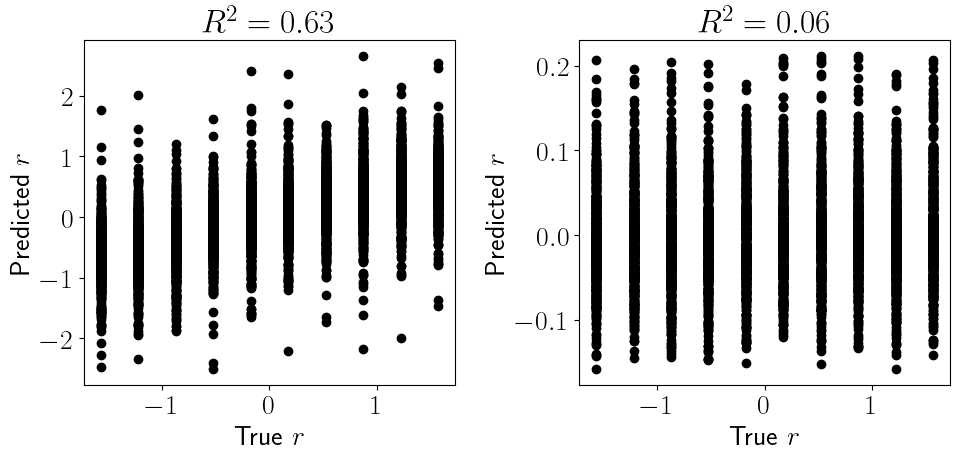

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(R, preds_contrastivereg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"$R^2 = " + str(round(r2_contrastivereg, 2)) + "$")

plt.subplot(122)
plt.scatter(R, preds_linreg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"$R^2 = " + str(round(r2_linreg, 2)) + "$")

plt.tight_layout()
plt.show()

In [14]:
# Now do this prediction experiment on held-out data
n_splits = 3
r2_scores_contrastivereg = []
r2_scores_linreg = []

kf = KFold(n_splits=n_splits, shuffle=True)
for train_index, test_index in kf.split(X):
    
    # Train/test split
    X_train, Y_train, R_train = X[train_index], Y[train_index], R[train_index]
    X_test, Y_test, R_test = X[test_index], Y[test_index], R[test_index]
    
    # Fit model on training data
    model = LinearSSCR()
    model.fit(X_train, Y_train, R_train, d, print_every=100, max_steps=500)
    
    # Make predictions
    preds_contrastivereg = model.predict(X_test)
    
    # Compute R^2
    _, _, r2_contrastivereg, _, _ = linregress(R_test.squeeze(), preds_contrastivereg)
    r2_scores_contrastivereg.append(r2_contrastivereg)
    
    linreg = LinearRegression()
    X_reduced = PCA(n_components=d).fit_transform(X)
    linreg.fit(X_reduced[train_index], R_train)
    preds_linreg = linreg.predict(X_reduced[test_index])
    _, _, r2_linreg, _, _ = linregress(R_test.squeeze(), preds_linreg.squeeze())
    r2_scores_linreg.append(r2_linreg)

Step: 0               Log marginal lik.: -2646694.0
Step: 100             Log marginal lik.: -740576.06
Step: 200             Log marginal lik.: -733988.31
Step: 300             Log marginal lik.: -732276.44
Step: 400             Log marginal lik.: -731414.44
Step: 0               Log marginal lik.: -2635444.0
Step: 100             Log marginal lik.: -745217.38
Step: 200             Log marginal lik.: -728948.0
Step: 300             Log marginal lik.: -722351.38
Step: 400             Log marginal lik.: -720408.75
Step: 0               Log marginal lik.: -2638512.5
Step: 100             Log marginal lik.: -740400.75
Step: 200             Log marginal lik.: -731900.31
Step: 300             Log marginal lik.: -727190.44
Step: 400             Log marginal lik.: -725043.38


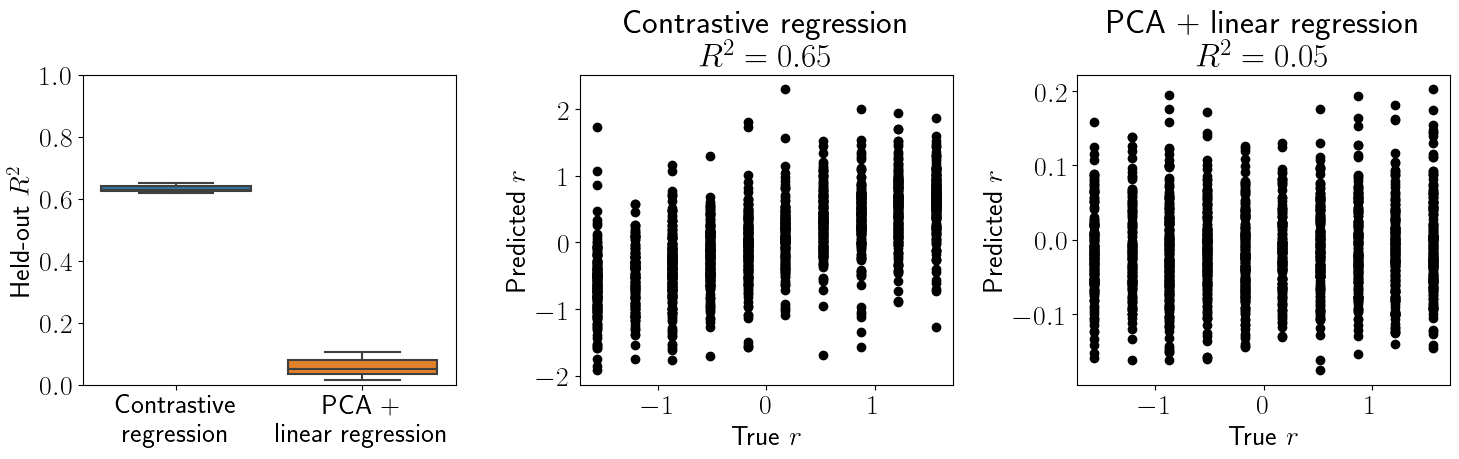

In [15]:
results_df = pd.DataFrame(
    {
        "Method": np.concatenate([["Contrastive\nregression"] * n_splits, ["PCA +\nlinear regression"] * n_splits]),
        "R2": np.concatenate([r2_scores_contrastivereg, r2_scores_linreg])
    }
)

plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.boxplot(data=results_df, x="Method", y="R2")
plt.xlabel("")
plt.ylabel(r"Held-out $R^2$")
plt.ylim([0, 1])

plt.subplot(132)
plt.scatter(R_test, preds_contrastivereg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title("Contrastive regression\n" + r"$R^2 = " + str(round(r2_contrastivereg, 2)) + "$")

plt.subplot(133)
plt.scatter(R_test, preds_linreg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title("PCA + linear regression\n" + r"$R^2 = " + str(round(r2_linreg, 2)) + "$")

plt.tight_layout()
plt.savefig("./out/corrupted_lines_preds.png")
plt.show()